In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import dask.array as da
import statsmodels.api as sm
import scipy.stats as stats

In [2]:
df = dd.read_csv("orders.csv", dtype = {
        "id" : "int", 
        "timestamp" : "int", 
        "market" : "category",
        "pair" : "str",
        "side" : "category",
        "quantity" : "float",
        "price" : "float",
        "order_type" : "category",
        "execution_time" : "float"
    }
)

## 02 Statistical Analysis

### (a) Identify any outliers in trade quantity and execution times

Checking for missing values

In [3]:
print(df.loc[:, "quantity"].isna().sum().compute())
print(df.loc[:, "execution_time"].isna().sum().compute())

0
0


Grouping into quantiles

In [4]:
quantity_q = df.loc[:, "quantity"].quantile(np.arange(.05, 1, .05)).compute()
exectime_q = df.loc[:, "execution_time"].quantile(np.arange(.05, 1, .05)).compute()

In [5]:
# Handle precision issues
quantity_q.index = quantity_q.index.round(2)
exectime_q.index = exectime_q.index.round(2)

Next, try to identify marginal outliers for each variable (through stratified plotting)

Distribution of quantity seems pretty uniform. At the extremes (lowest 5% and highest 5%), there are no obvious signs of outliers.

Text(0.5, 0.98, 'Distribution of Quantity')

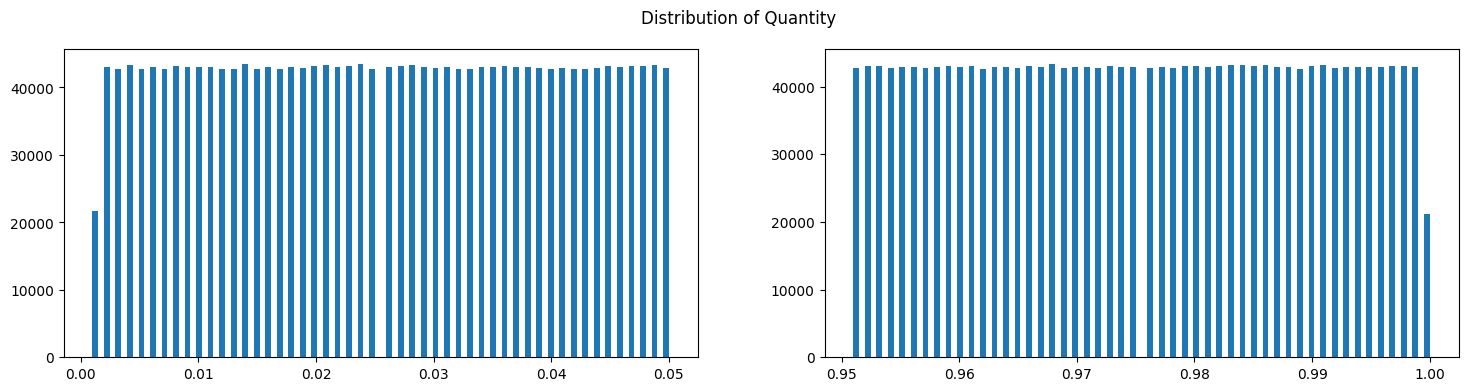

In [6]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 4))

pd_quantity = df.loc[:, "quantity"].compute()
_ = ax[0].hist(pd_quantity[pd_quantity < quantity_q.loc[0.05]], bins = 100)
_ = ax[1].hist(pd_quantity[pd_quantity > quantity_q.loc[0.95]], bins = 100)
fig.suptitle("Distribution of Quantity")

The same plot on execution time suggests that there the higher end of execution times have potential outliers, and deserves a deeper investigation.

Text(0.5, 0.98, 'Distribution of Execution Time')

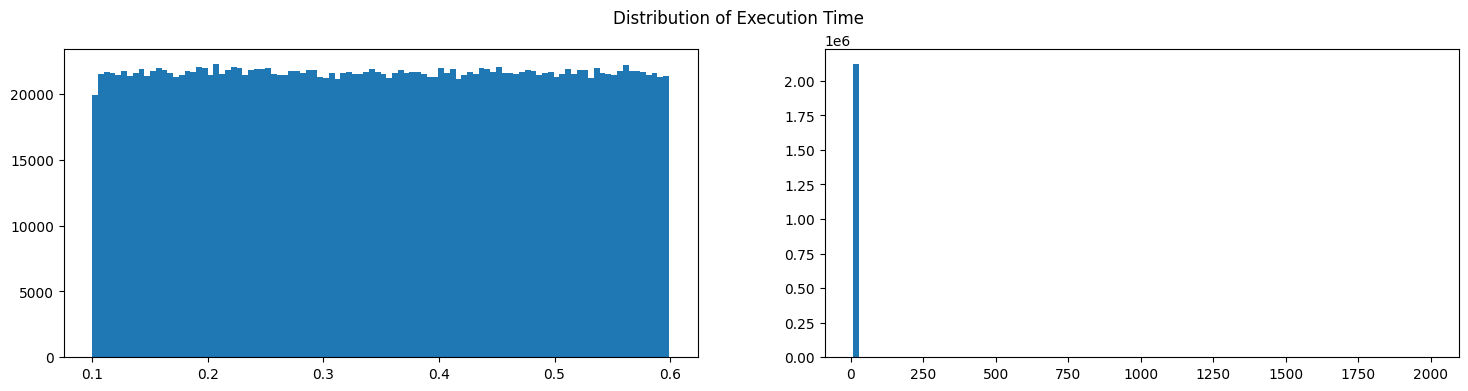

In [7]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 4))

pd_exectime = df.loc[:, "execution_time"].compute()
_ = ax[0].hist(pd_exectime[pd_exectime < exectime_q.loc[0.05]], bins = 100)
_ = ax[1].hist(pd_exectime[pd_exectime > exectime_q.loc[0.95]], bins = 100)
fig.suptitle("Distribution of Execution Time")

Further investigation shows that an execution time of 10ms sets a hard boundary on seemingly normal data, and outliers.
1. Execution time of less than or equal to 10ms seems to have a overall uniform histogram.
2. The shortest execution time once 10ms mark is passed is extremely high, at 1003.29.

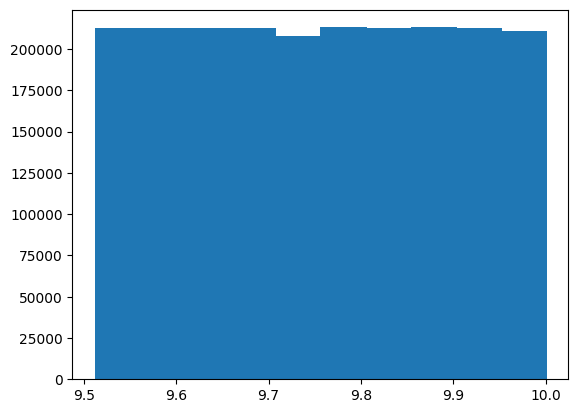

In [8]:
_ = plt.hist(pd_exectime[np.logical_and(pd_exectime > exectime_q.loc[0.95], pd_exectime <= 10)], width = 0.05)

In [9]:
print(pd_exectime[pd_exectime > 10].min())

1003.29


There are 500 of these "outlier" points, and all are occurring between 1000ms to 2000ms marks. Worth checking if the data points are errorneous.

In [10]:
outliers_exectime_bool = pd_exectime > 10
print(sum(outliers_exectime_bool))

500


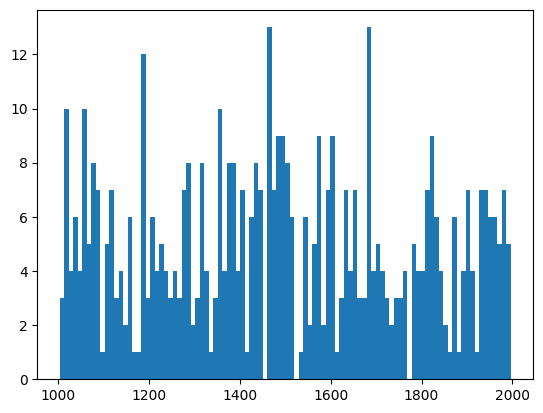

In [11]:
_ = plt.hist(pd_exectime[outliers_exectime_bool], bins = 100)

A quick check on jointly occurring outliers through a standardised Euclidean distance.

In [12]:
# Standardise the data
pd_std_quantity = (pd_quantity - pd_quantity.mean()) / pd_quantity.std()
pd_std_exectime = (pd_exectime - pd_exectime.mean()) / pd_exectime.std()

# Calculate Euclidean Distance from origin
radius = np.sqrt(pd_std_exectime ** 2 + pd_std_quantity ** 2)

Seems like there are no clear outliers jointly.

Text(0.5, 1.0, 'Outliers')

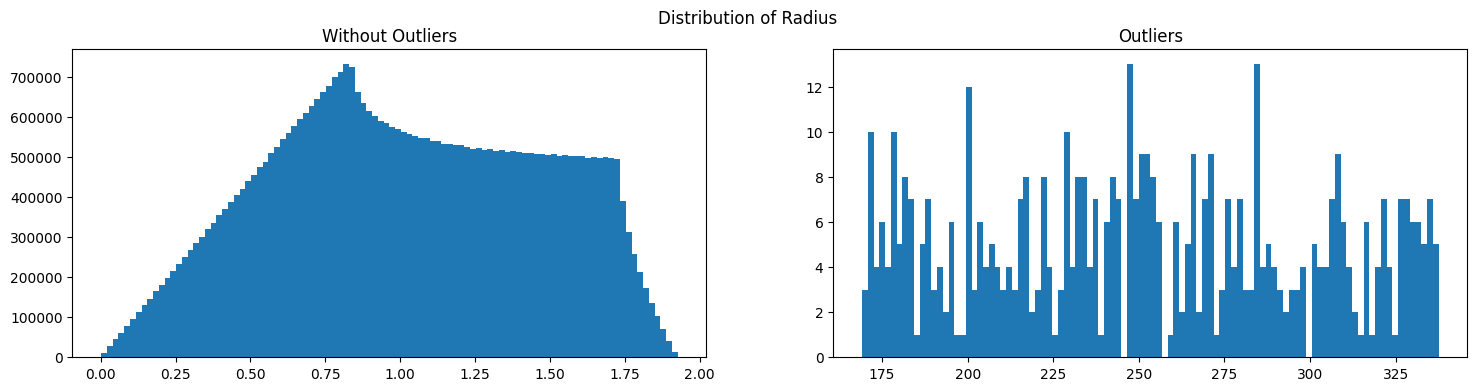

In [13]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 4))
_ = ax[0].hist(radius[~outliers_exectime_bool], bins = 100)
_ = ax[1].hist(radius[outliers_exectime_bool], bins = 100)
fig.suptitle("Distribution of Radius")
ax[0].set_title("Without Outliers")
ax[1].set_title("Outliers")

### (b.1) Compute average trade quantity

With or without Execution Time outlier points, the means of trade quantity are very similar

In [14]:
print(f"With Execution Time outlier samples: {pd_quantity.mean()}")
print(f"Without Execution Time outlier samples: {pd_quantity[~outliers_exectime_bool].mean()}")

With Execution Time outlier samples: 0.5004428456917266
Without Execution Time outlier samples: 0.5004429923921822


### (b.2) Build a distribution of execution time per market

In [15]:
pd_market = df.loc[:, "market"].compute()

Outliers seems to be of similar counts across different markets.

In [16]:
pd_market[outliers_exectime_bool].value_counts()

market
BINANCE    170
HUOBI      166
KRAKEN     164
Name: count, dtype: int64

Remove outliers

In [17]:
pd_market_exout = pd_market[~outliers_exectime_bool]
pd_exectime_exout = pd_exectime[~outliers_exectime_bool]

Splitting into different markets

In [18]:
sample_bin = pd_exectime_exout[pd_market_exout == "BINANCE"]
sample_huo = pd_exectime_exout[pd_market_exout == "HUOBI"]
sample_kra = pd_exectime_exout[pd_market_exout == "KRAKEN"]

All markets seem to have very similar distributions. Initial guess would be (for each market) $$Unif~[0, 10]$$

<Axes: title={'center': 'KRAKEN'}, ylabel='Frequency'>

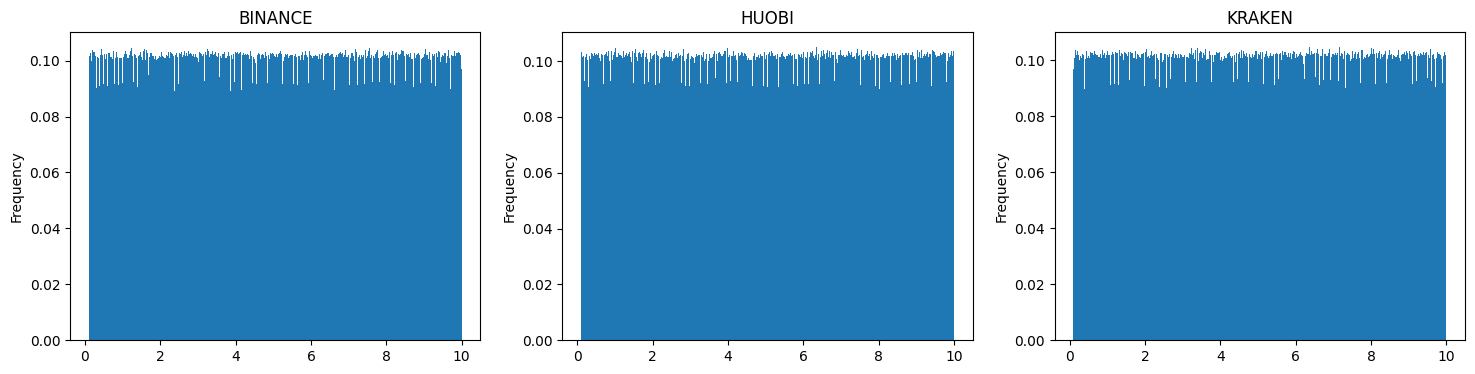

In [19]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (18, 4))
sample_bin.plot(kind = "hist", bins = 1000, density = True, ax = ax[0], title = "BINANCE")
sample_huo.plot(kind = "hist", bins = 1000, density = True, ax = ax[1], title = "HUOBI")
sample_kra.plot(kind = "hist", bins = 1000, density = True, ax = ax[2], title = "KRAKEN")

Plotting random samples of data from each market against a $ Unif~[0,10] $ distribution yields great qqplot. We shall accept the premise that the execution time per market are uniformly distributed.

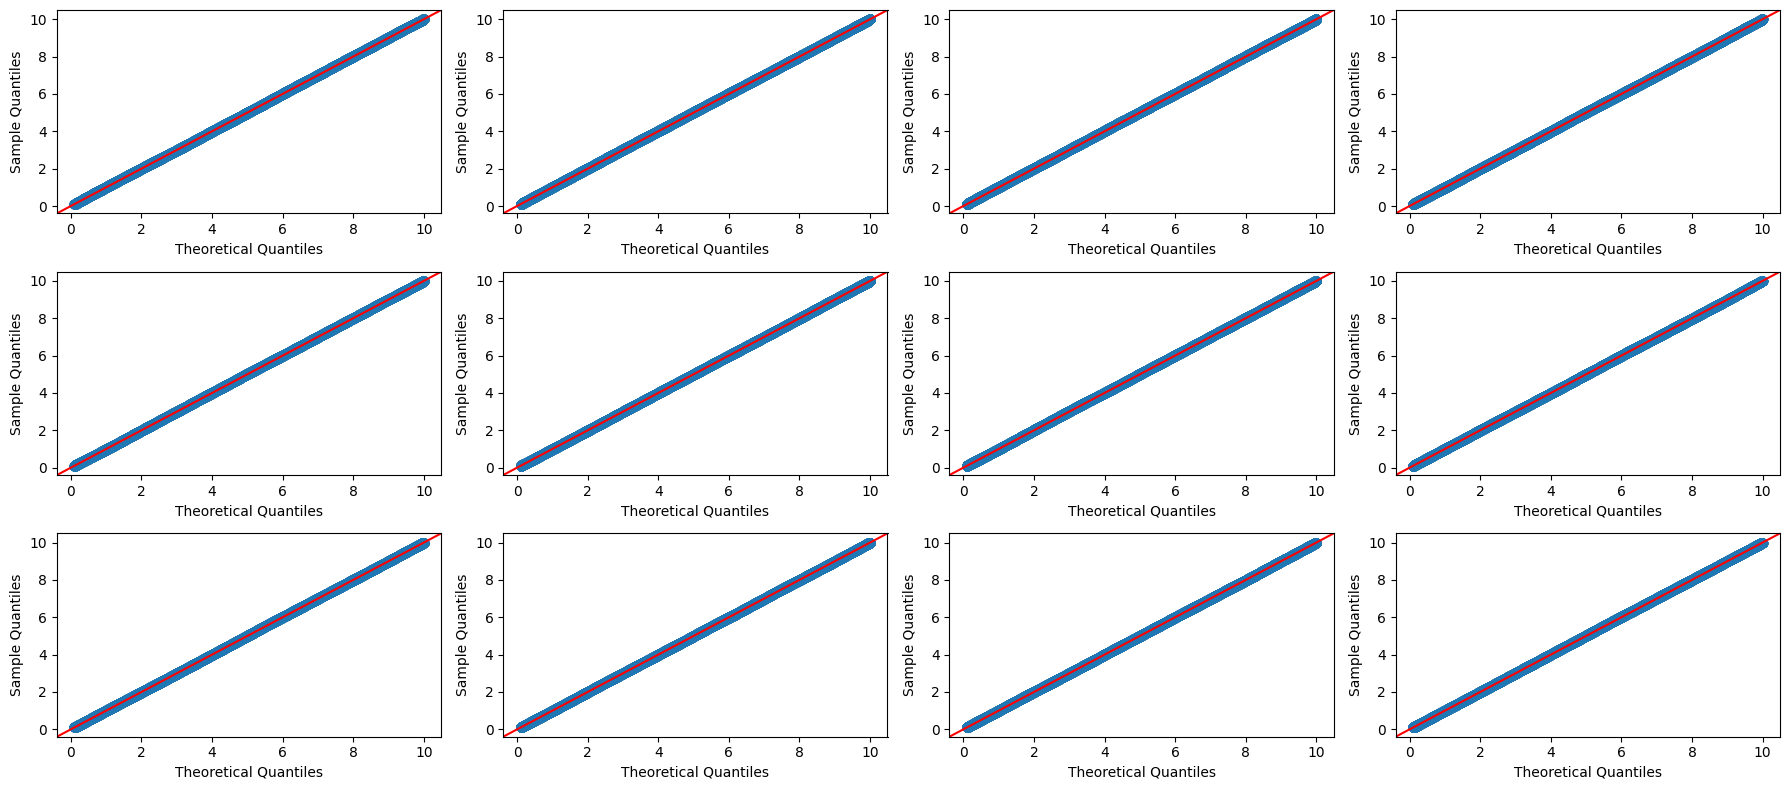

In [21]:
fig, ax = plt.subplots(nrows = 3, ncols = 4, figsize = (18, 8))

for i, sample in enumerate([sample_bin, sample_huo, sample_kra]):
    for j in range(4):
        sm.qqplot(sample.sample(100_000, random_state = j), dist = stats.distributions.uniform, loc = sample.min(), scale = sample.max() - sample.min(), line = '45', ax = ax[i, j])

fig.tight_layout()

Clear heavy data

In [22]:
del pd_exectime, pd_exectime_exout, pd_market, pd_market_exout, pd_quantity, pd_std_exectime, pd_std_quantity, radius

### (c) Aggregate into  10-minute OHLC and volume data